#### Looking at the UTRons assembled in bladder cancer expression levels within the simulation quantification databases

In [1]:
import pandas as pd
import sqlite3


cnx = sqlite3.connect('/shared/sudlab1/General/projects/utrons_project/Simulations/RealUtronsQuant/431bladderSimQuants.stringtie.db')# Connect to quant db
cnx.execute("ATTACH '/shared/sudlab1/General/projects/utrons_project/BladderCancerUtrons/431BladderUtrons.db' as utrons") # Attach real data db
cnx.execute("ATTACH '/shared/sudlab1/General/annotations/hg38_noalt_ensembl85/csvdb' as annotations") # Attach Annotations

In [2]:
# Get FPKM totals for each sample
query_text1 = '''
    SELECT sum(FPKM), q.track
    FROM agg_agg_agg_stringtie_transcript_data AS q
    GROUP BY q.track
    ORDER BY q.track
    '''
totals = pd.read_sql_query(query_text1, cnx)
totals = totals.groupby("track").sum() 

In [4]:

def getTpms(sample, run):
    query_text2 =   """
    SELECT t_name AS txId,ti.gene_name AS gene, FPKM
    FROM agg_agg_agg_stringtie_transcript_data AS q
    INNER JOIN utrons.novel_utrons_ids AS uid
    ON uid.transcript_id=q.t_name
    INNER JOIN annotations.transcript_info AS ti
    ON ti.transcript_id = uid.match_transcript_id
    WHERE uid.track='agg-agg-agg' AND q.track='"""+sample+"""' AND t_name like "MSTRG%"
    GROUP BY uid.transcript_id
    ORDER BY uid.transcript_id
    
                    """
    sampleTotal = totals.ix[sample][0]
    sampleQuants = pd.read_sql(query_text2, cnx)
    sampleQuants["TPM"] = (sampleQuants["FPKM"] / sampleTotal) * 1000000
    
    if run == 1:
        return sampleQuants[["txId","gene", "TPM"]]
    if run ==2:
        return sampleQuants["TPM"]
    
    
    

utronTpms = getTpms("GC-WT-1", 1)
for num in range(2,61,1):
    print num
    sample = "GC-WT-%d" %num
    sampleTpms = getTpms(sample, 2)
    utronTpms = pd.concat([utronTpms, sampleTpms], axis=1)

In [7]:
"""
Loop through a range of tpms and get the percent of utrons which quantify below the tpm threshold
"""

numGenes = len(utronTpms)
def getZeros(tpm): 
    allSamples = 0
    notallSamples = 0
    total = 0
    for gene in range(0, numGenes,1):
        geneTpms = utronTpms.ix[gene, 1:].tolist()
        if len([a for a in geneTpms if a <= tpm]) == 60:
            allSamples += 1
        else:
            notallSamples += 1
            
        total += 1
    percentage = float(allSamples) / total  
    return percentage
    
    
percentages = []
for num in [float(a)/10 for a in range(0,50, 2)]:
    print num,
    percentage = getZeros(num)
    percentages.append(percentage)

0.0 0.2 0.4 0.6 0.8 1.0 1.2 1.4 1.6 1.8 2.0 2.2 2.4 2.6 2.8 3.0 3.2 3.4 3.6 3.8 4.0 4.2 4.4 4.6 4.8


Populating the interactive namespace from numpy and matplotlib
[0.8795768917819365, 0.9377542717656632, 0.9491456468673718, 0.9544344995931652, 0.9593165174938975, 0.9621643612693247, 0.9654190398698128, 0.9703010577705452, 0.9743694060211554, 0.9776240846216436, 0.9800650935720098, 0.9808787632221319, 0.9812855980471928, 0.983319772172498, 0.984947111472742, 0.984947111472742, 0.9865744507729862, 0.9882017900732303, 0.9894222945484134, 0.9910496338486574, 0.9914564686737185, 0.9926769731489016, 0.9926769731489016, 0.9938974776240846, 0.9938974776240846]


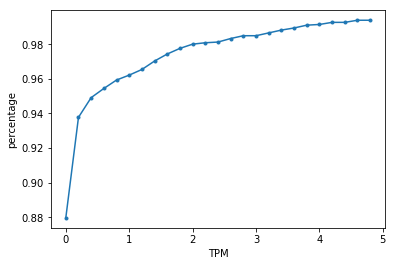

In [18]:
"""
Plot values from above
"""

%pylab inline
tpms = [float(a)/10 for a in range(0,50,2)]
print percentages
pylab.plot(tpms, percentages, marker=".")
pylab.ylabel("percentage"); pylab.xlabel("TPM")
pylab.savefig("./images/8_RealUtronQuantInSims", dpi=300)

In [16]:
"""
Print genes with samples which quantify as > 5 in any of the 60 samples
"""
filename = open("/shared/sudlab1/General/projects/utrons_project/misc_files/Utrons_5tpmInSims.txt", 'w')
for gene in range(0, numGenes,1):
        txName = utronTpms.ix[gene, 1]
        geneTpms = utronTpms.ix[gene, 2:].tolist()
        if len([a for a in geneTpms if a <= 5.0]) < 60:
            print txName, 
            txName = txName + "\n"
            filename.write(txName)
            
filename.close()

 SFN SHPK ITPKC SPECC1L RP11-949J7.8 RP11-949J7.8 FAM53A HARS HLA-DQA2 HEBP2 SLC37A3 CLN8 CLN8 CLN8


In [17]:
"""
Print genes with samples which quantify as > 2.5 in any of the 60 samples
"""
filename = open("/shared/sudlab1/General/projects/utrons_project/misc_files/Utrons_2.5tpmInSims.txt", 'w')
for gene in range(0, numGenes,1):
        txName = utronTpms.ix[gene, 1]
        geneTpms = utronTpms.ix[gene, 2:].tolist()
        if len([a for a in geneTpms if a <= 2.5]) < 60:
            print txName, 
            txName = txName + "\n"
            filename.write(txName)
            
filename.close()

SFN PPP2R2D PPP2R2D PPP2R2D IGF2 FADS1 FADS1 A2M TRABD2B PSME1 RP11-701H24.9 IDH2 SPATA33 SHPK SEC14L1 SEC14L1 SEC14L1 SEC14L1 SEC14L1 NEDD4L ITPKC SPECC1L RP11-949J7.8 RP11-949J7.8 FAM107A NUDT16 SSR3 FAM53A FAM47E-STBD1 LAMTOR3 LAMTOR3 LAMTOR3 C5orf63 HARS HLA-DQA2 HEBP2 TBXAS1 SLC37A3 CLN8 CLN8 CLN8 CLN8 NCMAP
